In [1]:
import itertools
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC
from src.estimation.gridsearch import (
    get_mask_around_diagonal,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.estimation.msm_criterion import (
    get_index_bundles,
    get_parallelizable_msm_criterion,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment, plot_infection_channels
from src.simulation.load_params import load_params
from src.simulation.load_simulation_inputs import load_simulation_inputs

# -----------------------------------------------------------------------------------

DEBUG = True
prefix = "delta"

# -----------------------------------------------------------------------------------


FALL_SIM_START = pd.Timestamp("2021-04-11")  # coincides with spring end!
FALL_SIM_END = pd.Timestamp("2021-07-01")

SPRING_SIM_START = pd.Timestamp("2021-07-02")
SPRING_SIM_END = pd.Timestamp("2021-08-26")

if DEBUG:
    FALL_SIM_END = FALL_SIM_START + pd.Timedelta(days=3)
    SPRING_SIM_END = SPRING_SIM_START + pd.Timedelta(days=3)

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)
%load_ext snakeviz

# Load the simulation inputs

In [2]:
params = load_params("baseline")

pmsm = get_parallelizable_msm_criterion(
    prefix=prefix,
    fall_start_date=FALL_SIM_START,
    fall_end_date=FALL_SIM_END,
    spring_start_date=SPRING_SIM_START,
    spring_end_date=SPRING_SIM_END,
    mode="fall",
    debug=DEBUG,
)

# Modify Params

In [3]:
delta_params = [("events", "delta_cases_per_100_000", "2021-06-01")]
rapid_reduc_params = [
    ("rapid_test_demand", "low_incidence_factor", "other_demand"),
    ("rapid_test_demand", "low_incidence_factor", "worker_demand"),
]
vacation_prob_params = [
    ("additional_other_vacation_contact", "probability", "Sommerferien2021")
]

free_params = delta_params + rapid_reduc_params + vacation_prob_params

# -----------------------------------------------------------------------------------
params.loc[delta_params] = 0.2
# -----------------------------------------------------------------------------------

params.loc[free_params]

value
category                          subcategory             name                   
events                            delta_cases_per_100_000 2021-06-01         0.20
rapid_test_demand                 low_incidence_factor    other_demand       0.25
                                                          worker_demand      0.25
additional_other_vacation_contact probability             Sommerferien2021   0.50

# Specify Grid

In [4]:
dimensions = "1d"

n_gridpoints = 10 if not DEBUG else 1
loc1 = delta_params
gridspec1 = (0.1, 0.25, n_gridpoints)

loc2 = None
gridspec2 = ("low", "high", n_gridpoints)

n_seeds = 20 if not DEBUG else 1
n_cores = 40 if not DEBUG else 1
mask = None

# Run estimation

In [5]:
if dimensions == "2d":
    results, grid, best_index, fig = run_2d_gridsearch(
        func=pmsm,
        params=params,
        loc1=loc1,
        gridspec1=gridspec1,
        loc2=loc2,
        gridspec2=gridspec2,
        n_seeds=n_seeds,
        n_cores=n_cores,
        mask=mask,
    )
else:
    results, grid, best_index, fig = run_1d_gridsearch(
        func=pmsm,
        params=params,
        loc=loc1,
        gridspec=gridspec1,
        n_seeds=n_seeds,
        n_cores=n_cores,
    )

Start the simulation...
2021-04-14: 100%|███████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]
Start the simulation...
2021-04-14: 100%|███████████████████████████████████████| 4/4 [00:02<00:00,  1.50it/s]


In [6]:
pd.to_pickle(results, "results.pkl")

# Plot Criterion Values

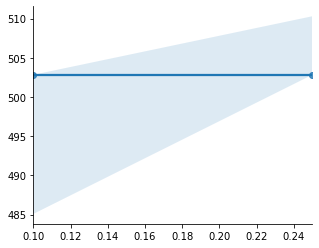

In [7]:
fig

# Plot Delta Shares

In [8]:
for g, res in zip(grid, results):
    print(g)
    plot_estimation_moment(res, "aggregated_delta_share")

0.1
0.25


# Plot Case Numbers

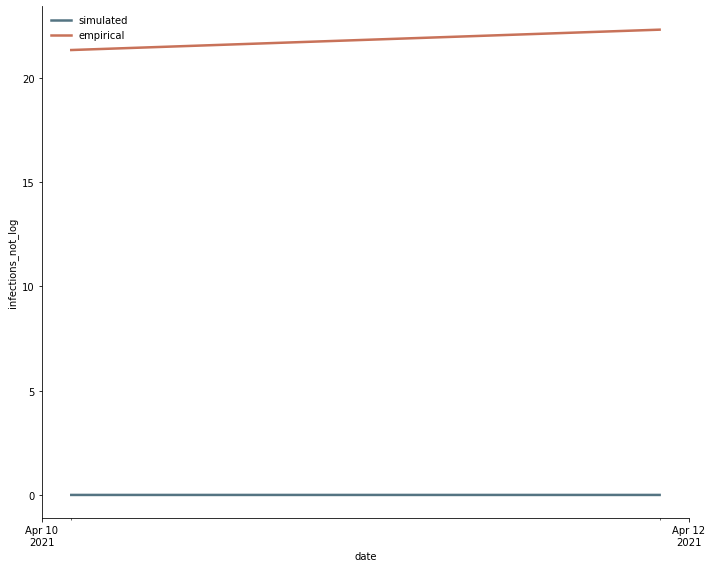

In [9]:
ix = best_index
plot_estimation_moment(results[ix], "aggregated_infections_not_log")

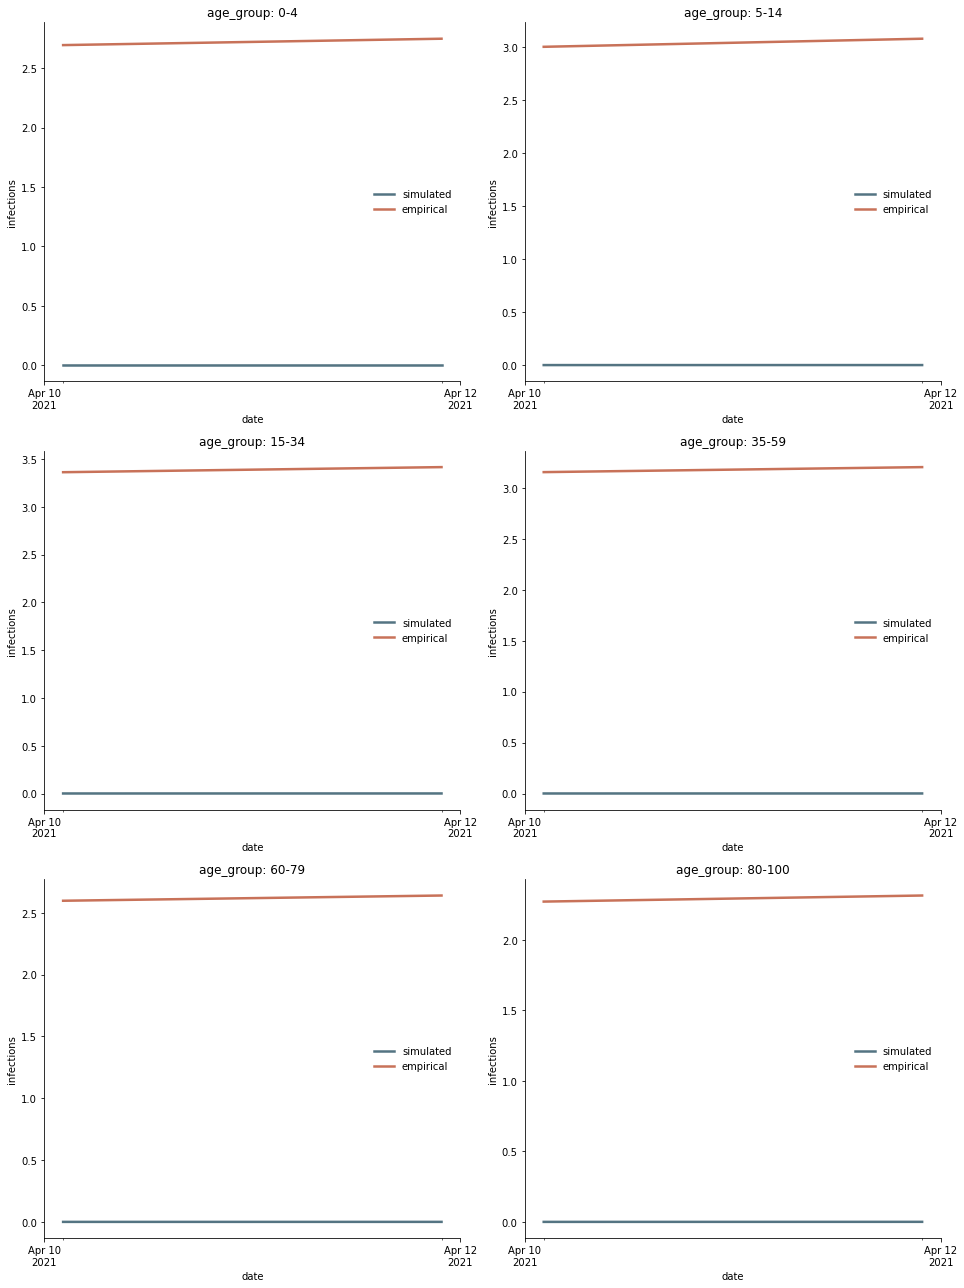

In [10]:
plot_estimation_moment(results[ix], "infections_by_age_group")

In [11]:
results[0][0].keys()

dict_keys(['value', 'root_contributions', 'empirical_moments', 'simulated_moments', 'infection_channels', 'share_known_cases'])

In [12]:
results[0][0]["simulated_moments"].keys()

dict_keys(['infections_by_age_group', 'aggregated_deaths', 'infections_by_state', 'aggregated_infections', 'infection_channels', 'currently_infected_by_age_group', 'knows_currently_infected_by_age_group', 'aggregated_infections_not_log', 'aggregated_b117_share', 'aggregated_delta_share'])